# Model Evaluation and Selection

## Imports

In [1]:
import os
import pandas as pd
import numpy as np
import warnings
import math
from best_model_selection import *

from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.metrics import silhouette_score
from hmmlearn.hmm import GaussianHMM, GMMHMM, MultinomialHMM

from dateutil.relativedelta import relativedelta
import seaborn
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
%matplotlib inline

In [2]:
from itertools import chain, combinations

def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(3, len(s)+1))

In [3]:
## GLOBAL VARS
DATE_TIME = 'date_time'
DATE = 'date'
TIME = 'time'
OPEN_PRICE = 'open'
HIGH_PRICE = 'high'
LOW_PRICE = 'low'
CLOSE_PRICE = 'close'
VOLUME = 'volume'
TURNOVER = 'turnover'
VWAP = 'vwap'
FEATURES = ['high_low_spread', "open_close_rets", "log_total_traded_vol", "daily_log_return", "short_term_vol", "long_term_vol", "money_flow_index"]

## Functions

In [18]:
def ric_ticker_dict(ticker):
    ric_ticker = {'AAPL': 'AAPL.OQ', 
                  'AIR': 'AIR.PA', 
                  'BBVA.MC': 'BBVA.MC', 
                  'BMW': 'BMWG.DE', 
                  'BA': 'BA.N', 
                  'CBK': 'CBKG.DE', 
                  'E-DGE': 'DGE.L', 
                  'ES': 'SP 500', 
                  'ENGI': 'ENGIE.PA', 
                  'GE': 'GE.N', 
                  'GILD': 'GILD.OQ', 
                  'E-GSK': 'GSK.L', 
                  'IBE.MC': 'IBE.MC', 
                  'MEL.MC': 'MEL.MC', 
                  'MSFT': 'MSFT.OQ', 
                  'NESN': 'NESS.N', 
                  'NOKIA': 'NOKIA.HE', 
                  'REE.MC': 'REE.MC', 
                  'GLE': 'GLE.PA', 
                  'TMUS': 'TMUS.O', 
                  'TEF.MC': 'TEF.MC', 
                  'E-TSCO': 'TSCO.L', 
                  'VIV': 'VIV.PA', 
                  'WMT': 'WMT.N', 
                  'ED': 'BUND', 
                  'EO': 'BOBL'}
    
    return ric_ticker.get(ticker)

In [19]:
def loadData(file):
    filepath = os.path.join(DATAPATH, file)
    df = pd.read_csv("file:///" + filepath, parse_dates=[['<DTYYYYMMDD>', '<TIME>']])

    return df

def formatData(df):
    returned_df = df.copy()
    returned_df.drop(labels=["<PER>", "<OPENINT>"], axis="columns", inplace=True)
    returned_df.columns = ['date_time', 'ticker', 'open', 'high', 'low', 'close', 'volume']
    returned_df.set_index('date_time', drop=True, inplace=True)
    returned_df = addDateAndTime(returned_df)

    return returned_df

def prepareDataframe(df):
    returned_df = df.copy()
    returned_df['volume*price'] = returned_df['volume']*returned_df['close']
    returned_df = returned_df.resample('5T').sum()
    returned_df = returned_df.between_time('9:00', '17:25')
    returned_df = returned_df[returned_df.index.weekday != 5]
    returned_df = returned_df[returned_df.index.weekday != 6]
    returned_df['vwap'] = returned_df['volume*price']/returned_df['volume']

    return returned_df

def splitTrainTestData(df, size_in_years):
#     training_data = df[df.index[0]:df.index[0] + relativedelta(years=size_in_years, hours=-9, minutes = -5)]
#     test_data = df[df.index[0] + relativedelta(years=size_in_years, hours=-9):]
    training_data = df[df.index[0]:df.index[-1] - relativedelta(years=size_in_years, hours=-9, minutes = -5)]
    test_data = df[df.index[-1] - relativedelta(years=size_in_years, hours=-9):]

    return training_data, test_data

def getWeekdaysData(df):
    df_mondays = df[df.index.weekday == 0]
    df_tuesdays = df[df.index.weekday == 1]
    df_wednesdays = df[df.index.weekday == 2]
    df_thursdays = df[df.index.weekday == 3]
    df_fridays = df[df.index.weekday == 4]

    return df_mondays, df_tuesdays, df_wednesdays, df_thursdays, df_fridays

def getWeekdaysDataDict(df):
    weekdaysDataDict = {}
    weekdaysDataDict[0] = df[df.index.weekday == 0]
    weekdaysDataDict[1] = df[df.index.weekday == 1]
    weekdaysDataDict[2] = df[df.index.weekday == 2]
    weekdaysDataDict[3] = df[df.index.weekday == 3]
    weekdaysDataDict[4] = df[df.index.weekday == 4]
    weekdaysDataDict['else'] = df

    return weekdaysDataDict
  
def getDataByWeekDay(df, weekday):
    df_weekday = df[df.index.weekday == weekday]

    return df_weekday

def addDateAndTime(df):
    returned_df = df.copy()
    returned_df['date'] = pd.to_datetime(returned_df.index.date)
    returned_df['time'] = pd.to_datetime(returned_df.index, format = "%m-%d-%Y %H:%M:%S")
    returned_df['time'] = returned_df['time'].apply(lambda x: x.strftime('%H:%M:%S'))

    return returned_df

def get_log_total_trade_vol(df):
    log_total_traded_vol = get_log(get_total_traded_vol(df))
    log_total_traded_vol.name = "log_total_traded_vol"
    
    return log_total_traded_vol 

def get_total_traded_vol(df):
    total_traded_vol = df.resample('B').first()[[VOLUME]]
    total_traded_vol.drop(labels=total_traded_vol.index.get_values()[0], axis='index', inplace=True)
    total_traded_vol.name = "total_traded_vol"

    return total_traded_vol

def get_log_open_close_returns(df):
    open_close_returns = np.log(df[OPEN_PRICE]/df[CLOSE_PRICE].shift(-1)).dropna()
    open_close_returns.name = "log_overnight_returns"

    return open_close_returns

def get_log_returns(df):
    close = df[CLOSE_PRICE].resample('B').last()
    log_daily_returns = np.log(close/close.shift(-1))
    log_daily_returns.name = "log_returns"

    return log_daily_returns

def get_high_low_spread(df):
    high_low_spread = (df[HIGH_PRICE]-df[LOW_PRICE])
    high_low_spread.name = "high_low_spread"

    return high_low_spread

def get_log(df):
    return np.log(df)

def get_antilog_adv_median(df):
    antilog_adv = np.exp(get_log(df[VOLUME]).rolling(30, min_periods=5).median().dropna())
    antilog_adv.name = "antilog_adv"
    
    return antilog_adv

def get_money_flow_index(df):
    typical_price = (df[CLOSE_PRICE]+df[HIGH_PRICE]+df[LOW_PRICE])/3
    volume = df[VOLUME]
    money_flow_index = typical_price*volume
    money_flow_index.name = "money_flow_index"

    return money_flow_index

def get_beta_market_impact(df):
    adv_antilog = get_antilog_adv_median(df)
    X = df[VOLUME]/adv_antilog
    Y = ((df[VWAP]-df[OPEN_PRICE])/df[OPEN_PRICE])*1e4
    betas = Y/X
    betas.name = "betas_market_impact"
    
    return betas

def getFeaturesDf(list_of_features):
    features_df = pd.concat(list_of_features, axis=1).dropna()
    features_df = features_df.replace([np.inf, -np.inf], np.nan)
    features_df = features_df.dropna()
    features_df = features_df[features_df != 0.0].shift(1).dropna()

    return features_df

def fit_model_to_evaluate(model, train_data, pca_flag=True):
    X = train_data.values
    scaler = MinMaxScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)

    if pca_flag:
        pca = PCA(n_components=2)
        pca.fit(X_scaled)
        X_pca = pca.transform(X_scaled)
        fitted_model = model.fit(X_pca)
    else:
        fitted_model = model.fit(X_scaled)
        pca = None

    return pca, scaler, fitted_model

def get_daily_data(df):
    daily_data = df.groupby(df.index.date).agg({OPEN_PRICE: "first", 
                                                LOW_PRICE: "min",
                                                HIGH_PRICE: "max", 
                                                CLOSE_PRICE: "last", 
                                                VOLUME: "sum", 
                                                TURNOVER: "sum"})
    daily_data[VWAP] = daily_data.turnover/daily_data.volume
    daily_data = daily_data[daily_data[VOLUME] > 0.1]
    daily_data = daily_data[(daily_data.index != 6) & (daily_data.index != 7)]
    daily_data.index = pd.to_datetime(daily_data.index)
    daily_data = daily_data.resample('B').first()
    daily_data.dropna(inplace=True)
    
    
    return daily_data

In [20]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covars_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)
        
def plot_ellipsis(model, label=True, ax=None):
    ax = ax or plt.gca()
    w_factor = 0.2 / gmm.weights_.max()
    
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

In [21]:
warnings.filterwarnings("ignore")
DATAPATH = os.getcwd()+"\\Data\\"
filepath_anon = os.path.join(DATAPATH, "volume_price_2014_18.csv")

## Importing data

In [22]:
files_list = []
for root, dirs, files in os.walk(DATAPATH):
    for file in files:
        files_list.append(file)

In [9]:
files_list

['AAPL.txt',
 'AIR_AIRBUS.txt',
 'BBVA_MC.txt',
 'BMW_BMW.txt',
 'BOEING.txt',
 'COMMERZBANK.txt',
 'DIAGEO.txt',
 'E-MINI SP 500.txt',
 'ENGIE.txt',
 'EURO BOBL.txt',
 'EURO BUND.txt',
 'GENERAL ELECTRIC.txt',
 'GILEAD.txt',
 'GSK.txt',
 'IBERDROLA.txt',
 'MELIA.txt',
 'MSFT.txt',
 'NESTLE.txt',
 'NOKIA.txt',
 'REE.txt',
 'SOCGEN.txt',
 'T-MOBILE.txt',
 'TEF.txt',
 'TESCO.txt',
 'VIVENDI.txt',
 'WALMART.txt']

In [12]:
raw = pd.read_csv("file:///" + os.path.join(DATAPATH, files_list[3]), parse_dates=[['<DTYYYYMMDD>', '<TIME>']])

df = formatData(raw)

# df = df[df.index.year >= 2014]

current_ticker = df.ticker.iloc[0]

open_time = df.time.min()
last_time = df.time.max()
close_time = df[df[TIME] != df.time.max()].time.max()

df[TURNOVER] = df[VOLUME]*df[CLOSE_PRICE]

df_resampled = df.resample('5T').sum()

df_resampled = df_resampled[(df_resampled.index.weekday != 5) | (df_resampled.index.weekday != 6)]

df_resampled[VWAP] = df_resampled[TURNOVER]/df_resampled[VOLUME]
intraday_data = df_resampled.copy()

daily_data = get_daily_data(df)

train_intraday_data, test_data = splitTrainTestData(intraday_data, 2)

## Generate features

In [13]:
log_returns = get_log_returns(daily_data)
adv_antilog = get_antilog_adv_median(daily_data)
mfi = get_money_flow_index(daily_data)
betas_mkt_impact = get_beta_market_impact(daily_data)
log_traded_vol = get_log_total_trade_vol(daily_data)

# features = [log_returns, adv_antilog, mfi, betas_mkt_impact, log_traded_vol]
# features = [adv_antilog, mfi]
# features = [log_returns, betas_mkt_impact, log_traded_vol, adv_antilog]
features = [betas_mkt_impact, log_returns, log_traded_vol]

features_df = getFeaturesDf(features)

train_data, test_data = splitTrainTestData(features_df, 2)

### Gaussian Mixture Model

In [205]:
# prior_weights = [0.40, 0.40, 0.1, 0.1]
model = GaussianMixture(n_components=3, max_iter=500, n_init=3)

pca, scaler, gmm = fit_model_to_evaluate(model, train_data, len(features_df.columns))

In [206]:
if pca is not None:
    modeled_test_data = pca.transform(scaler.transform(test_data.values))
else:
    modeled_test_data = scaler.transform(test_data.values)

print("Akaike information for test data: {}".format(gmm.aic(modeled_test_data)))
print("Bayesian information criteria for test data: {}".format(gmm.bic(modeled_test_data)))
print("Per-sample average log-likelihood for test data: {}".format(gmm.score(modeled_test_data)))
print("Silhouette score for test data: {}".format(silhouette_score(modeled_test_data, gmm.predict(modeled_test_data))))

Akaike information for test data: -3380.6666975693834
Bayesian information criteria for test data: -3308.318946859576
Per-sample average log-likelihood for test data: 3.277031379625128
Silhouette score for test data: 0.27804772747242273


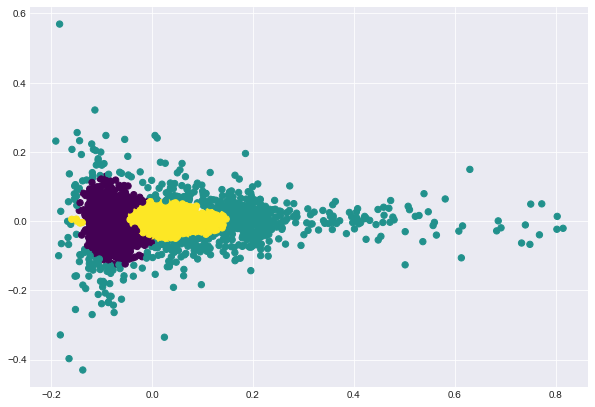

In [207]:
if pca is not None:
    full_data = pca.transform(scaler.transform(features_df.values))
else:
    full_data = scaler.transform(features_df.values)

predictions = gmm.predict(full_data)
plt.figure(figsize=(10,7))
plt.scatter(full_data[:, 0], full_data[:, 1], c=predictions, s=40, cmap='viridis');

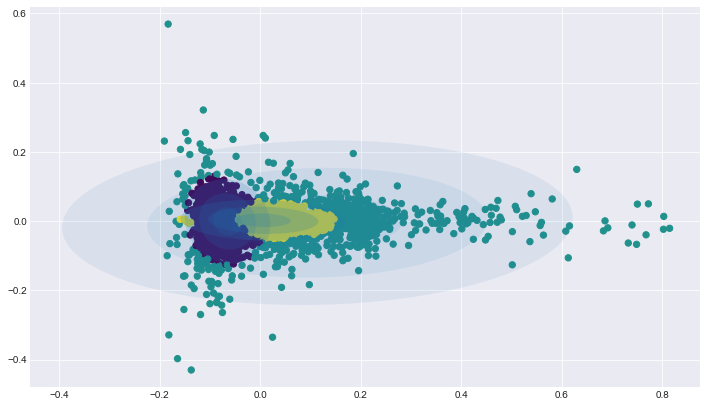

In [208]:
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111)
ax.scatter(full_data[:, 0], full_data[:, 1], c=predictions, s=40, cmap='viridis');
plot_ellipsis(model, ax=ax)

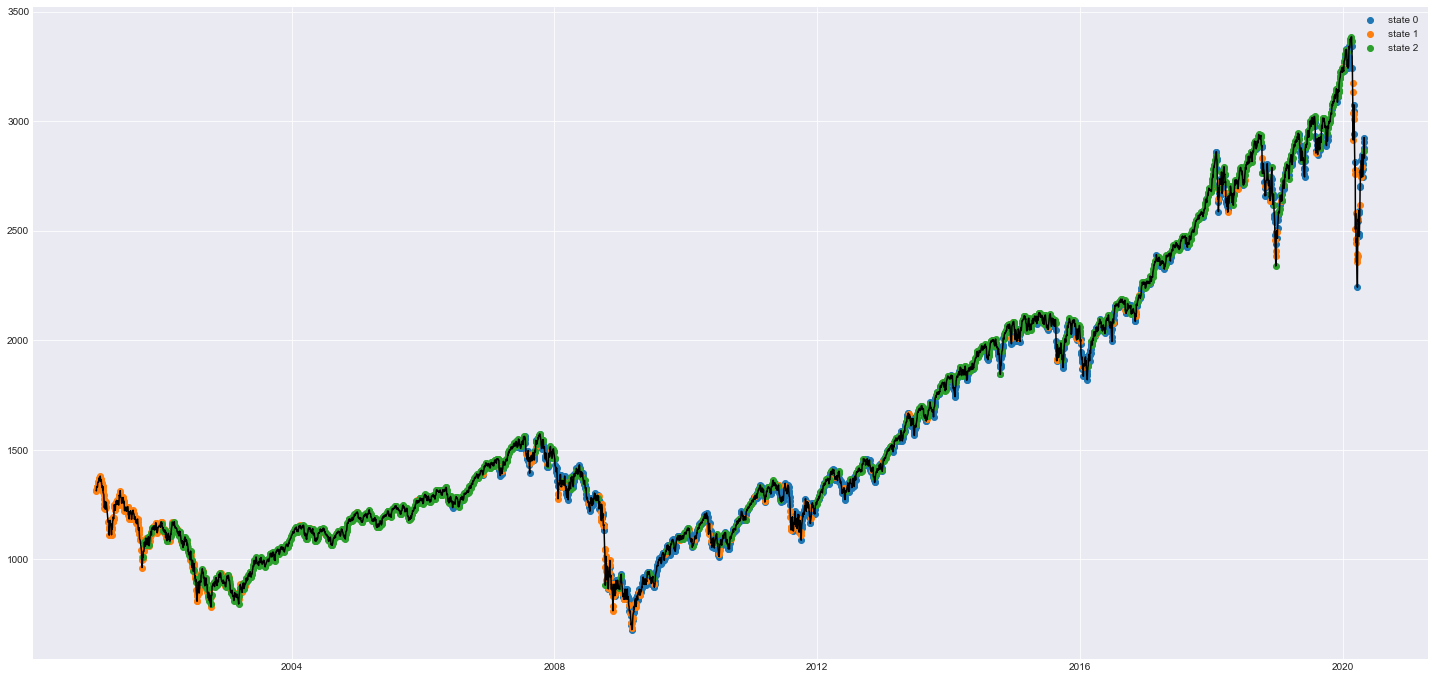

In [209]:
fig = plt.figure(figsize=(25,12))
ax = fig.add_subplot(111)
times = features_df.index
for pred_label in np.unique(predictions):
    mask = predictions == pred_label
    ax.scatter(times[mask], daily_data[daily_data.index.isin(times[mask])][VWAP], label="state " + str(pred_label))
ax.plot(times, daily_data[daily_data.index.isin(times)][VWAP], 'black');
plt.legend();

### Bayesian Gaussian Mixture Model

In [213]:
model = BayesianGaussianMixture(n_components=3, max_iter=300)

pca, scaler, bgmm = fit_model_to_evaluate(model, train_data, len(features_df.columns))

In [214]:
if pca is not None:
    modeled_test_data = pca.transform(scaler.transform(test_data.values))
else:
    modeled_test_data = scaler.transform(test_data.values)

print("Per-sample average log-likelihood for test data: {}".format(bgmm.score(modeled_test_data)))
print("Silhouette score for test data: {}".format(silhouette_score(modeled_test_data, bgmm.predict(modeled_test_data))))

Per-sample average log-likelihood for test data: 3.2943934467339173
Silhouette score for test data: 0.30979152753083383


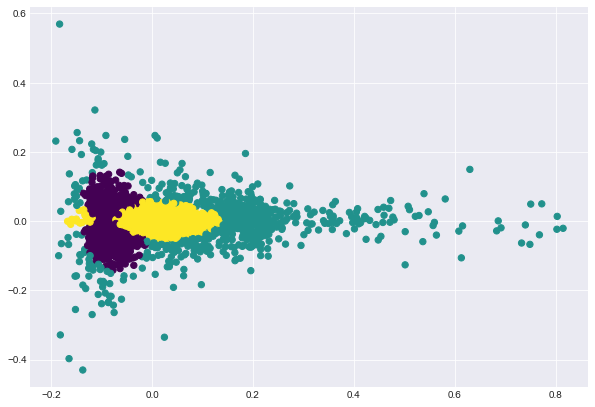

In [215]:
if pca is not None:
    full_data = pca.transform(scaler.transform(features_df.values))
else:
    full_data = scaler.transform(features_df.values)

predictions = bgmm.predict(full_data)
plt.figure(figsize=(10,7))
plt.scatter(full_data[:, 0], full_data[:, 1], c=predictions, s=40, cmap='viridis');

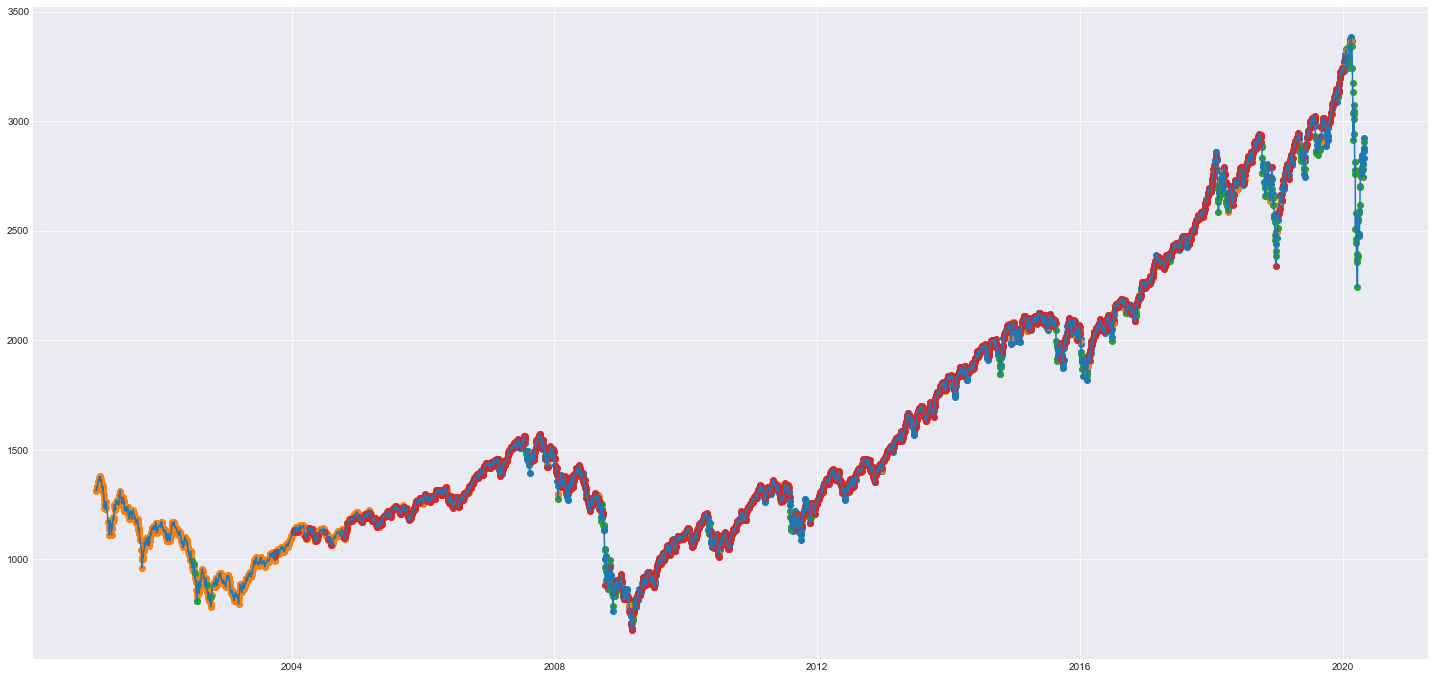

In [191]:
fig = plt.figure(figsize=(25,12))
ax = fig.add_subplot(111)
times = features_df.index
for pred_label in np.unique(predictions):
    mask = predictions == pred_label
    ax.scatter(times[mask], daily_data[daily_data.index.isin(times[mask])][VWAP])
ax.plot(times, daily_data[daily_data.index.isin(times)][VWAP]);

### Hidden Markov Model

In [29]:
model = GaussianHMM(n_components=4, covariance_type="full", n_iter=100)

pca, scaler, ghmm = fit_model_to_evaluate(model, train_data, len(features_df.columns))

In [30]:
if pca is not None:
    modeled_test_data = pca.transform(scaler.transform(test_data.values))
else:
    modeled_test_data = scaler.transform(test_data.values)

print("Per-sample average log-likelihood for test data: {}".format(bgmm.score(modeled_test_data)))
print("Silhouette score for test data: {}".format(silhouette_score(modeled_test_data, ghmm.predict(modeled_test_data))))

Per-sample average log-likelihood for test data: 1.177637853350732
Silhouette score for test data: 0.28933232211734583


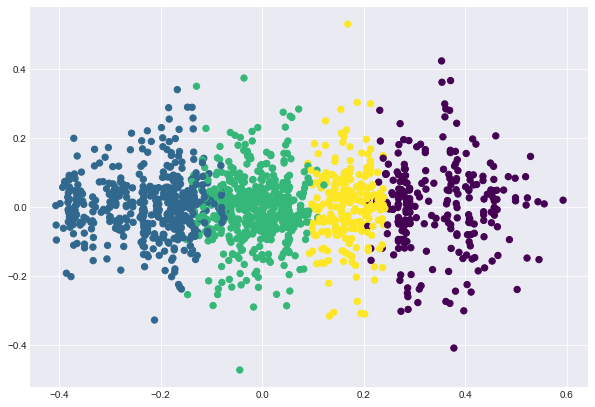

In [31]:
if pca is not None:
    full_data = pca.transform(scaler.transform(features_df.values))
else:
    full_data = scaler.transform(features_df.values)

predictions = ghmm.predict(full_data)
plt.figure(figsize=(10,7))
plt.scatter(full_data[:, 0], full_data[:, 1], c=predictions, s=40, cmap='viridis');

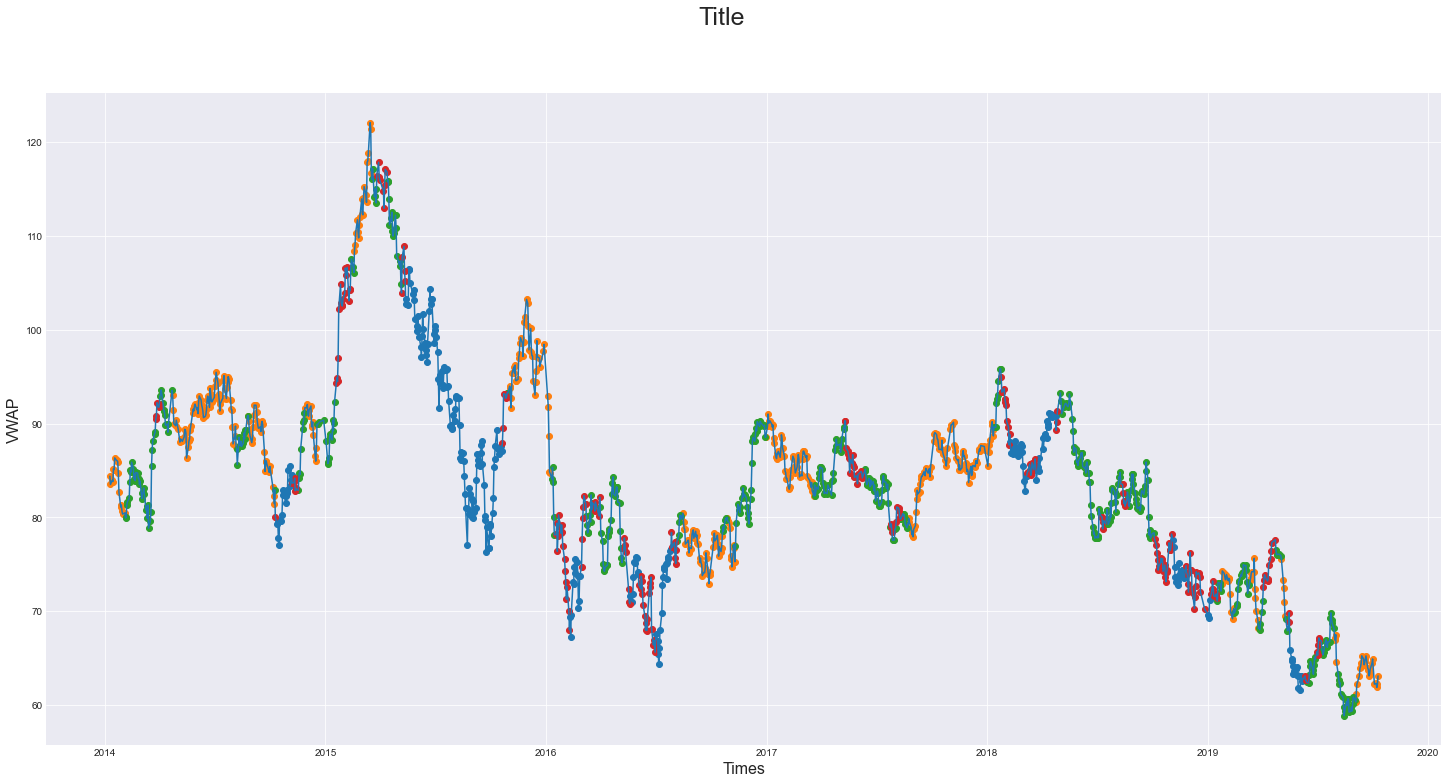

In [32]:
fig = plt.figure(figsize=(25,12))
ax = fig.add_subplot(111)
fig.suptitle("Title", fontsize=25)
plt.xlabel("Times", fontsize=16)
plt.ylabel("VWAP", fontsize=16)
times = features_df.index
for pred_label in np.unique(predictions):
    mask = predictions == pred_label
    ax.scatter(times[mask], daily_data[daily_data.index.isin(times[mask])][VWAP])
ax.plot(times, daily_data[daily_data.index.isin(times)][VWAP]);

## Eval

In [12]:
raw = pd.read_csv("file:///" + os.path.join(DATAPATH, files_list[7]), parse_dates=[['<DTYYYYMMDD>', '<TIME>']])

df = formatData(raw)
current_ticker = df.ticker.iloc[0]

open_time = df.time.min()
last_time = df.time.max()
close_time = df[df[TIME] != df.time.max()].time.max()

df[TURNOVER] = df[VOLUME]*df[CLOSE_PRICE]

df_resampled = df.resample('5T').sum()

df_resampled = df_resampled[(df_resampled.index.weekday != 5) | (df_resampled.index.weekday != 6)]

df_resampled[VWAP] = df_resampled[TURNOVER]/df_resampled[VOLUME]
intraday_data = df_resampled.copy()

daily_data = get_daily_data(df)

train_intraday_data, test_data = splitTrainTestData(intraday_data, 2)

## Generate features

In [13]:
log_returns = get_log_returns(daily_data)
adv_antilog = get_antilog_adv_median(daily_data)
mfi = get_money_flow_index(daily_data)
betas_mkt_impact = get_beta_market_impact(daily_data)
log_traded_vol = get_log_total_trade_vol(daily_data)

features = [log_traded_vol, betas_mkt_impact, mfi, adv_antilog, log_returns]

features_df = getFeaturesDf(features)

train_data, test_data = splitTrainTestData(features_df, 2)

In [15]:
best_gmm, features_gmm, scores_gmm = get_best_gmm_aic_bic(features, pca_flag=False)
best_ghmm, features_ghmm,scores_ghmm = get_best_ghmm_aic_bic(features, pca_flag=False)
best_bgm, features_bgm, scores_bgm = get_best_bgm_aic_bic(features, pca_flag=False)

Optimal params are {'n_components': 4, 'covariance_type': 'full', 'max_iter': 200} using ['volume', 'betas_market_impact', 'money_flow_index', 'antilog_adv', 'log_returns'] obtaining a Combined BIC-AIC score of -84671.9326505849
Scores obtained -> BIC: -84407.46851636557, AIC: -84936.39678480424, SC: 0.3775425677146312


KeyboardInterrupt: 

### Gaussian Mixture Model

In [30]:
train_gmm, test_gmm = splitTrainTestData(features_df[features_gmm], 2)
full_data_gmm = features_df[features_gmm]

In [31]:
pca, scaler, gmm = fit_model_to_evaluate(best_gmm, train_gmm, pca_flag=False)

In [32]:
if pca is not None:
    modeled_test_data = pca.transform(scaler.transform(test_gmm.values))
else:
    modeled_test_data = scaler.transform(test_gmm.values)
    
if pca is not None:
    full_data = pca.transform(scaler.transform(full_data_gmm.values))
else:
    full_data = scaler.transform(full_data_gmm.values)

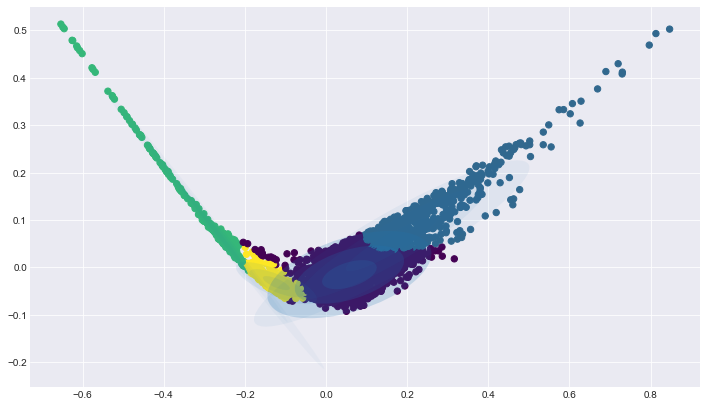

In [34]:
# fig = plt.figure(figsize=(12,7))
# ax = fig.add_subplot(111)
# ax.scatter(full_data[:, 0], full_data[:, 1], c=predictions, s=40, cmap='viridis');
# plot_ellipsis(gmm, ax=ax)

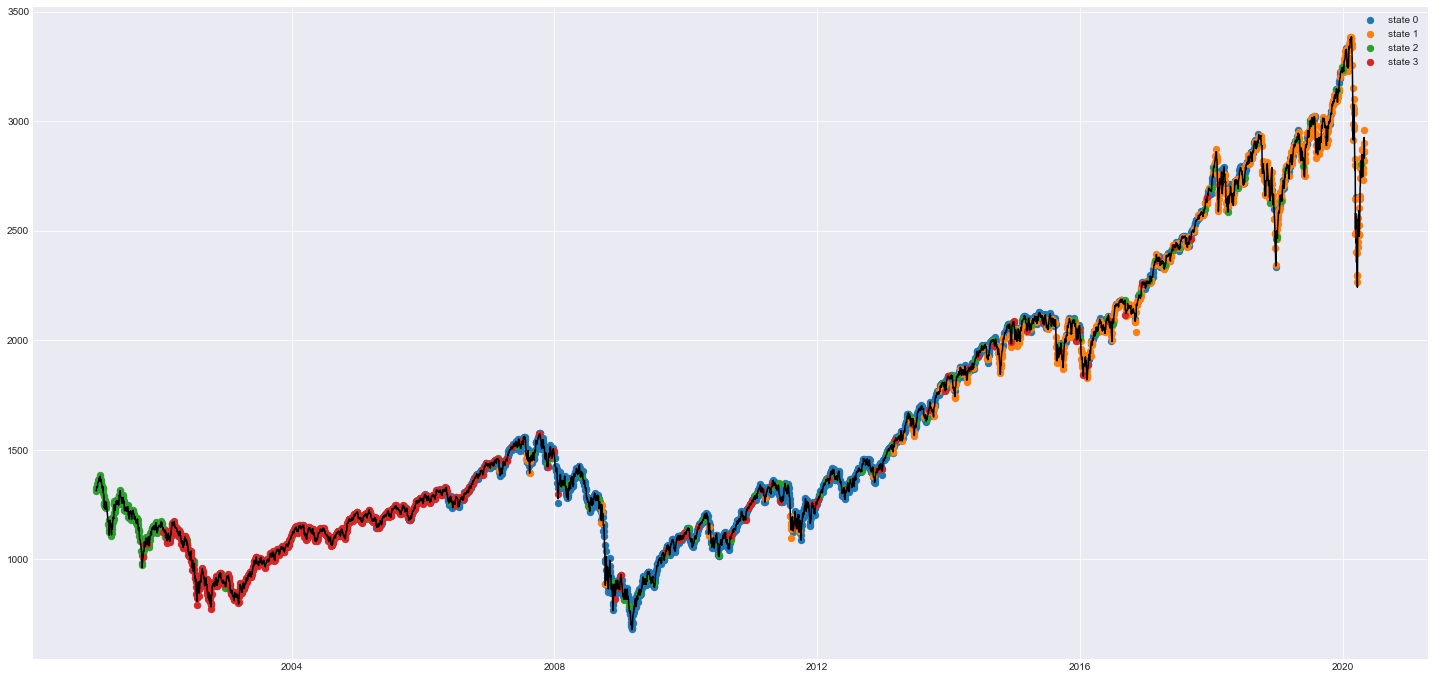

In [35]:
fig = plt.figure(figsize=(25,12))
ax = fig.add_subplot(111)
times = full_data_gmm.index
for pred_label in np.unique(predictions):
    mask = predictions == pred_label
    ax.scatter(times[mask], daily_data[daily_data.index.isin(times[mask])]['close'], label="state " + str(pred_label), s=40, cmap='viridis')
ax.plot(times, daily_data[daily_data.index.isin(times)][VWAP], 'black');
plt.legend();

### Bayesian Gaussian Mixture

In [36]:
train_bgm, test_bgm = splitTrainTestData(features_df[features_bgm], 2)
full_data_bgm = features_df[features_bgm]

In [37]:
pca, scaler, bgm = fit_model_to_evaluate(best_bgm, train_bgm, len(features_bgm))

In [38]:
if pca is not None:
    modeled_test_data = pca.transform(scaler.transform(test_bgm.values))
else:
    modeled_test_data = scaler.transform(test_bgm.values)

# print("Akaike information for test data: {}".format(gmm.aic(modeled_test_data)))
# print("Bayesian information criteria for test data: {}".format(gmm.bic(modeled_test_data)))
# print("Per-sample average log-likelihood for test data: {}".format(gmm.score(modeled_test_data)))
# print("Silhouette score for test data: {}".format(silhouette_score(modeled_test_data, gmm.predict(modeled_test_data))))

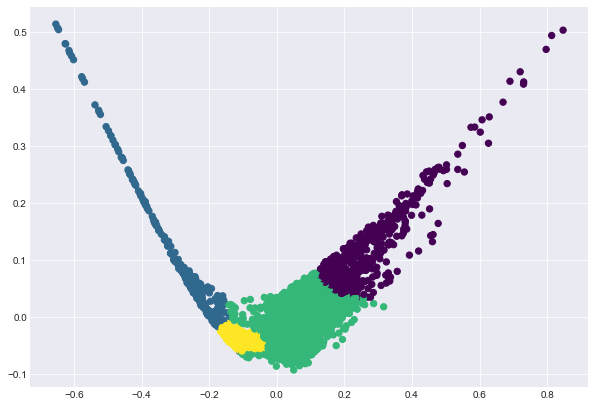

In [39]:
if pca is not None:
    full_data = pca.transform(scaler.transform(full_data_bgm.values))
else:
    full_data = scaler.transform(full_data_bgm.values)

predictions = bgm.predict(full_data)
plt.figure(figsize=(10,7))
plt.scatter(full_data[:, 0], full_data[:, 1], c=predictions, s=40, cmap='viridis');

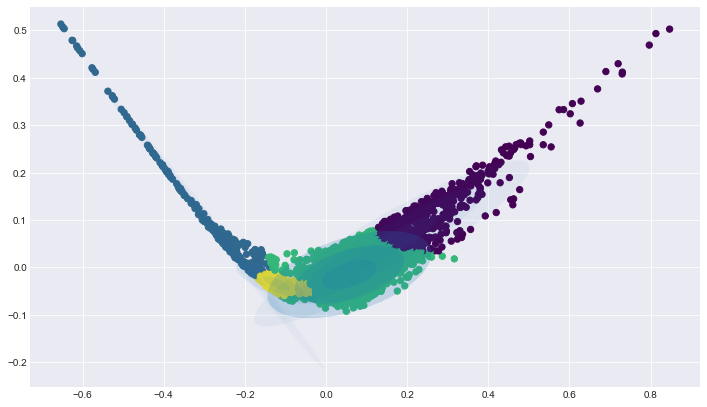

In [40]:
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111)
ax.scatter(full_data[:, 0], full_data[:, 1], c=predictions, s=40, cmap='viridis');
plot_ellipsis(bgm, ax=ax)

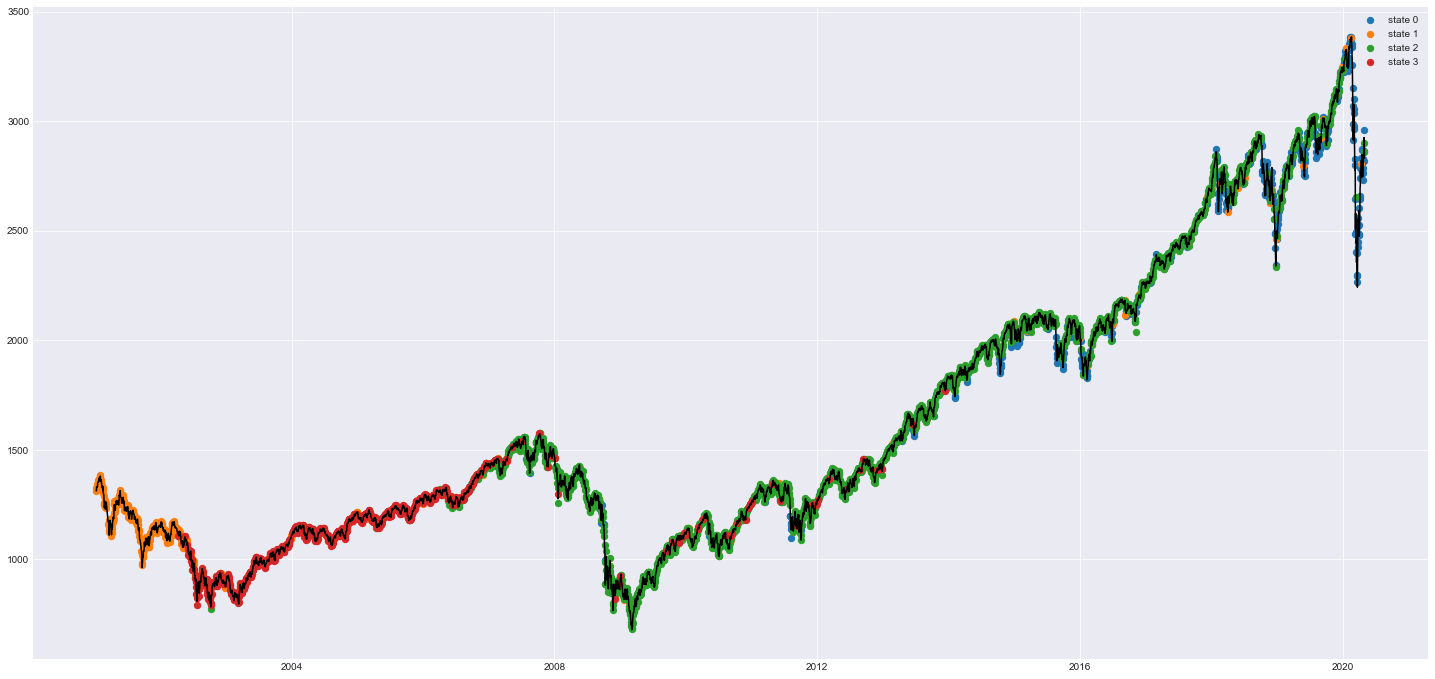

In [41]:
fig = plt.figure(figsize=(25,12))
ax = fig.add_subplot(111)
times = full_data_bgm.index
for pred_label in np.unique(predictions):
    mask = predictions == pred_label
    ax.scatter(times[mask], daily_data[daily_data.index.isin(times[mask])]['close'], label="state " + str(pred_label), s=40, cmap='viridis')
ax.plot(times, daily_data[daily_data.index.isin(times)][VWAP], 'black');
plt.legend();

### Gaussian Hidden Markov Model

In [42]:
train_ghmm, test_ghmm = splitTrainTestData(features_df[features_ghmm], 2)
full_data_ghmm = features_df[features_ghmm]

In [43]:
pca, scaler, ghmm = fit_model_to_evaluate(best_ghmm, train_ghmm, len(features_ghmm))

In [44]:
if pca is not None:
    modeled_test_data = pca.transform(scaler.transform(test_ghmm.values))
else:
    modeled_test_data = scaler.transform(test_ghmm.values)

# print("Akaike information for test data: {}".format(gmm.aic(modeled_test_data)))
# print("Bayesian information criteria for test data: {}".format(gmm.bic(modeled_test_data)))
# print("Per-sample average log-likelihood for test data: {}".format(gmm.score(modeled_test_data)))
# print("Silhouette score for test data: {}".format(silhouette_score(modeled_test_data, gmm.predict(modeled_test_data))))

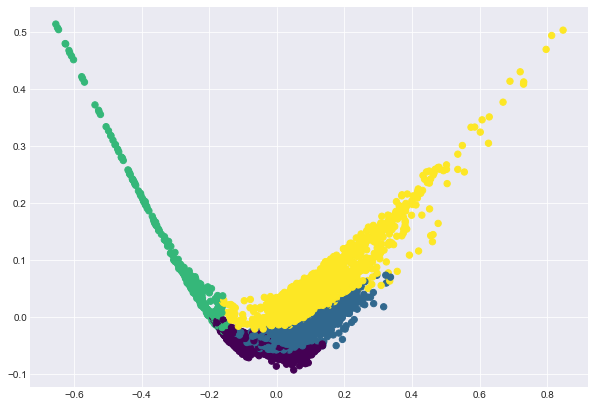

In [45]:
if pca is not None:
    full_data = pca.transform(scaler.transform(full_data_ghmm.values))
else:
    full_data = scaler.transform(full_data_ghmm.values)

predictions = ghmm.predict(full_data)
plt.figure(figsize=(10,7))
plt.scatter(full_data[:, 0], full_data[:, 1], c=predictions, s=40, cmap='viridis');

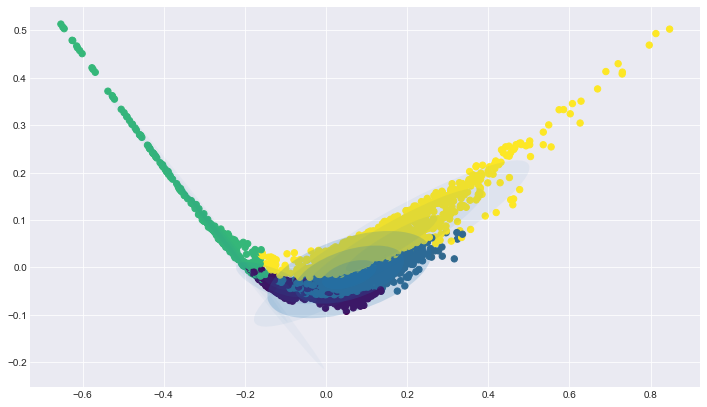

In [46]:
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111)
ax.scatter(full_data[:, 0], full_data[:, 1], c=predictions, s=40, cmap='viridis');
plot_ellipsis(ghmm, ax=ax)

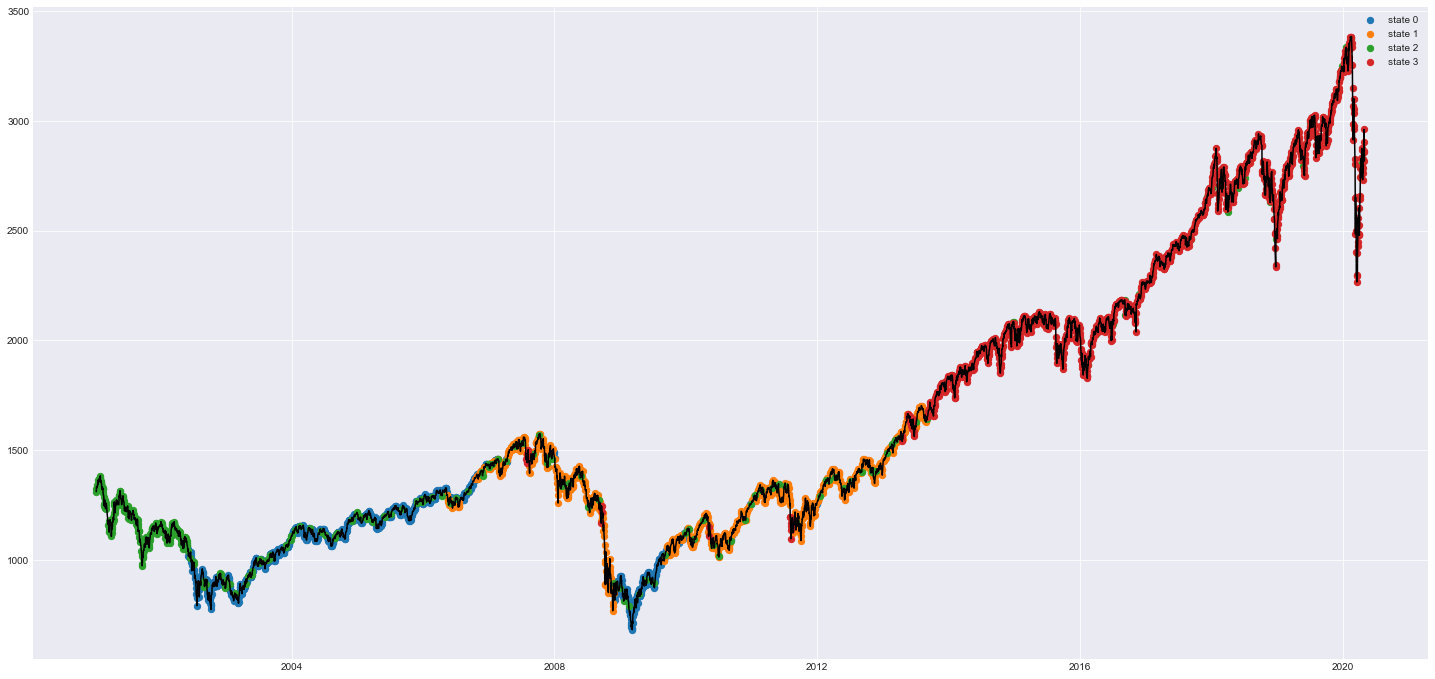

In [47]:
fig = plt.figure(figsize=(25,12))
ax = fig.add_subplot(111)
times = full_data_bgm.index
for pred_label in np.unique(predictions):
    mask = predictions == pred_label
    ax.scatter(times[mask], daily_data[daily_data.index.isin(times[mask])]['close'], label="state " + str(pred_label), s=40, cmap='viridis')
ax.plot(times, daily_data[daily_data.index.isin(times)]['close'], 'black');
plt.legend();

### Test without pca

In [63]:
best_gmm, features_gmm = get_best_gmm_aic_bic(features, pca_flag=False)

Optimal params are {'n_components': 4, 'covariance_type': 'full', 'max_iter': 100} using ['volume', 'betas_market_impact', 'money_flow_index', 'antilog_adv', 'log_returns'] obtaining a Combined BIC-AIC score of -84669.38767235517
Scores obtained -> BIC: -84404.92353813583, AIC: -84933.8518065745, SC: 0.3775425677146312


In [64]:
train_gmm, test_gmm = splitTrainTestData(features_df[features_gmm], 2)
full_data_gmm = features_df[features_gmm]

In [87]:
pca, scaler, gmm = fit_model_to_evaluate(best_gmm, train_gmm, len(features_gmm), pca_flag=True)

In [90]:
pca

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [88]:
if pca is not None:
    modeled_test_data = pca.transform(scaler.transform(test_gmm.values))
else:
    modeled_test_data = scaler.transform(test_gmm.values)

# print("Akaike information for test data: {}".format(gmm.aic(modeled_test_data)))
# print("Bayesian information criteria for test data: {}".format(gmm.bic(modeled_test_data)))
# print("Per-sample average log-likelihood for test data: {}".format(gmm.score(modeled_test_data)))
# print("Silhouette score for test data: {}".format(silhouette_score(modeled_test_data, gmm.predict(modeled_test_data))))

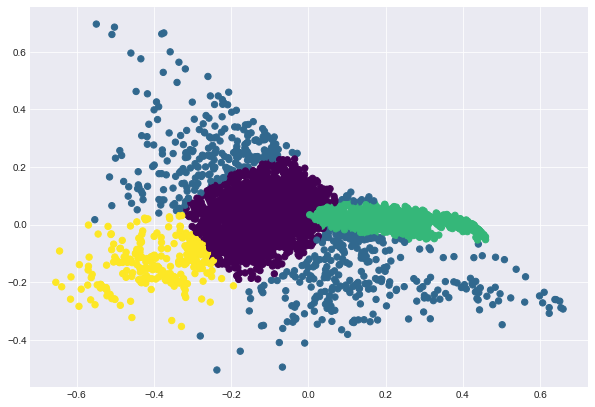

In [92]:
if pca is not None:
    full_data = pca.transform(scaler.transform(full_data_gmm.values))
else:
    full_data = scaler.transform(full_data_gmm.values)

predictions = gmm.predict(full_data)
plt.figure(figsize=(10,7))
plt.scatter(full_data[:, 0], full_data[:, 1], c=predictions, s=40, cmap='viridis');

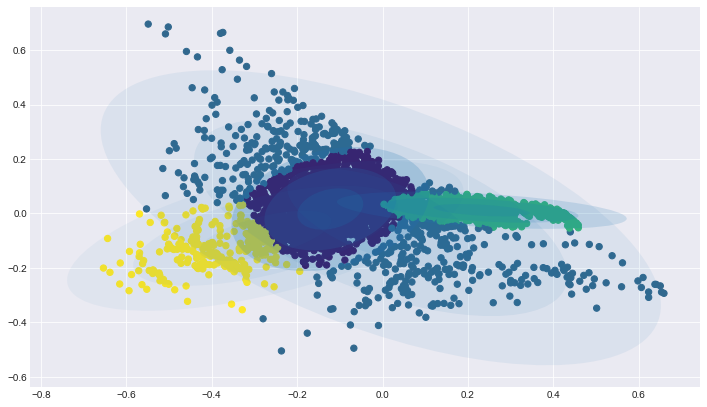

In [94]:
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111)
ax.scatter(full_data[:, 0], full_data[:, 1], c=predictions, s=40, cmap='viridis');
plot_ellipsis(gmm, ax=ax)

**PCA**

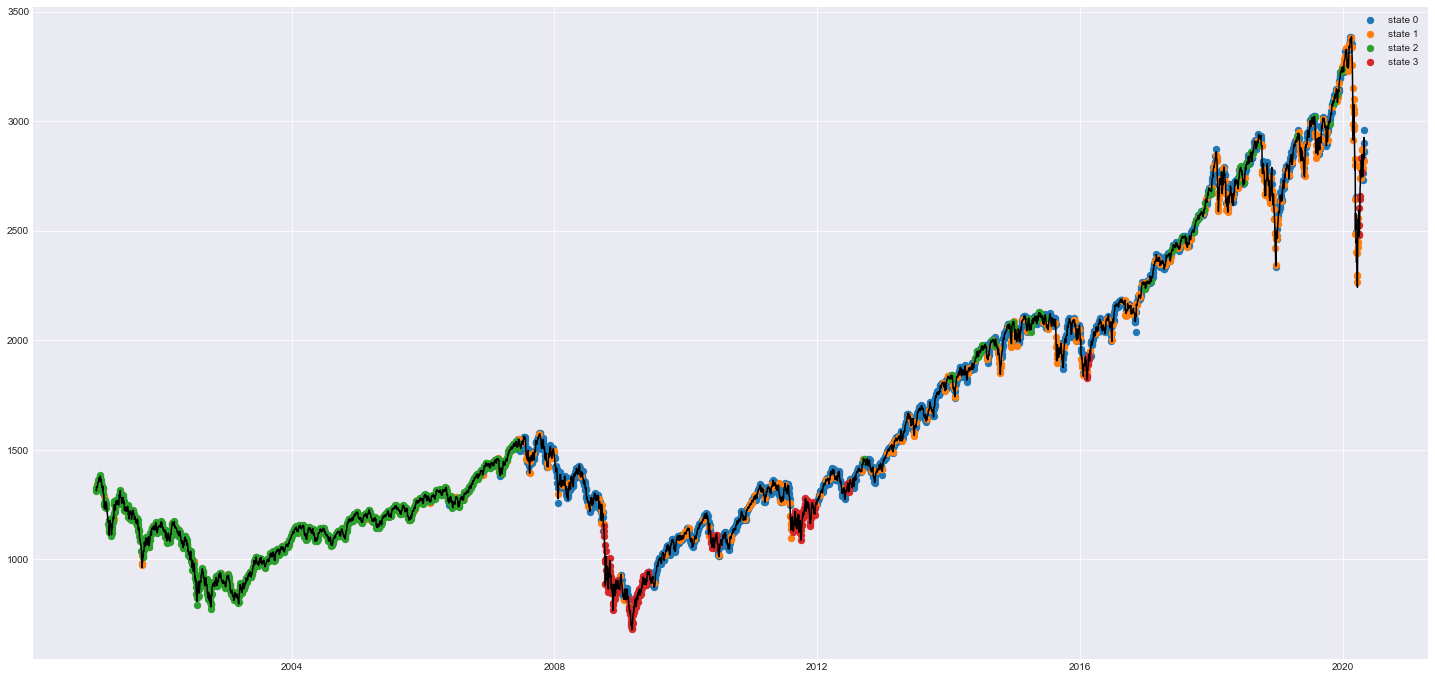

In [95]:
fig = plt.figure(figsize=(25,12))
ax = fig.add_subplot(111)
times = full_data_gmm.index
for pred_label in np.unique(predictions):
    mask = predictions == pred_label
    ax.scatter(times[mask], daily_data[daily_data.index.isin(times[mask])]['close'], label="state " + str(pred_label), s=40, cmap='viridis')
ax.plot(times, daily_data[daily_data.index.isin(times)][VWAP], 'black');
plt.legend();

**NO PCA**

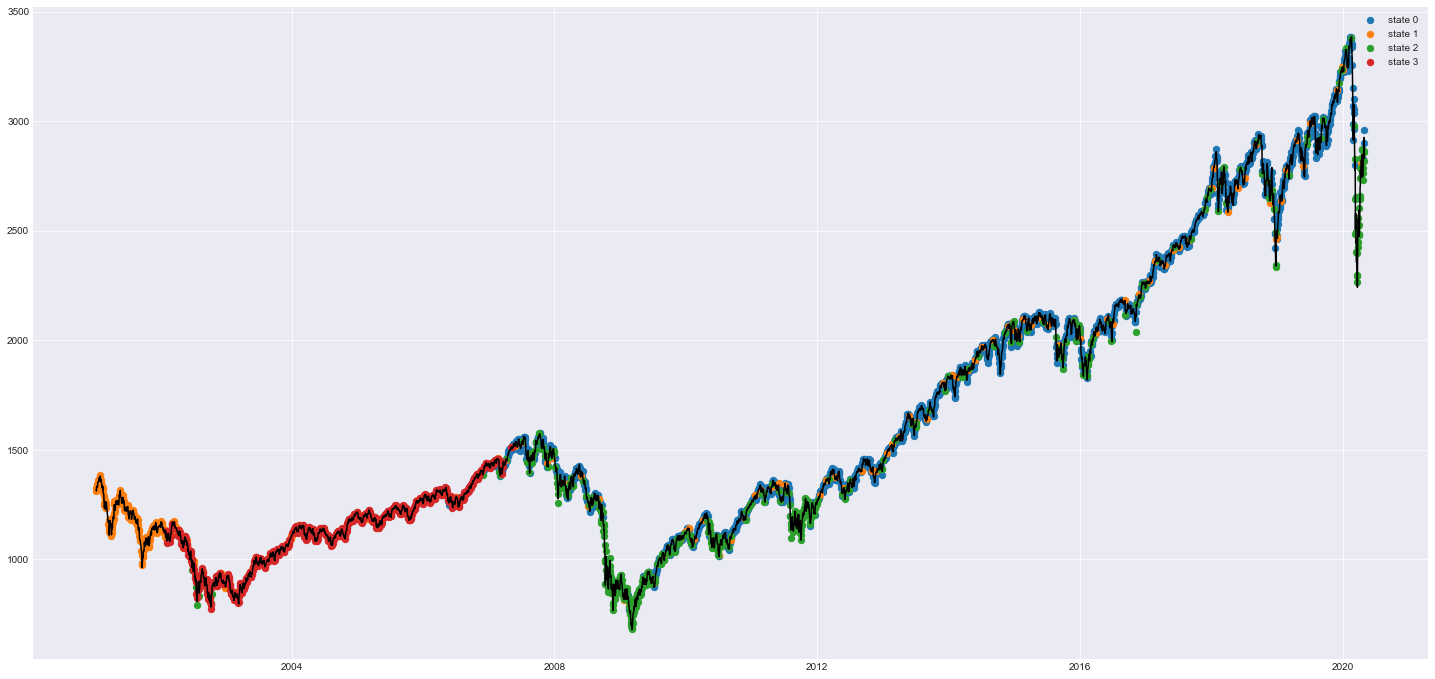

In [81]:
fig = plt.figure(figsize=(25,12))
ax = fig.add_subplot(111)
times = full_data_gmm.index
for pred_label in np.unique(predictions):
    mask = predictions == pred_label
    ax.scatter(times[mask], daily_data[daily_data.index.isin(times[mask])]['close'], label="state " + str(pred_label), s=40, cmap='viridis')
ax.plot(times, daily_data[daily_data.index.isin(times)][VWAP], 'black');
plt.legend();

### Plotting

In [17]:
def plot_time_series_states(model, daily_data, features_df, features_to_use, ax, plot_title):
    train, test = splitTrainTestData(features_df[features_to_use], 2)
    data_to_use = features_df[features_to_use]

    pca, scaler, model_fitted = fit_model_to_evaluate(model, train, pca_flag=False)
    if pca is not None:
        full_data = pca.transform(scaler.transform(data_to_use.values))
    else:
        full_data = scaler.transform(data_to_use.values)
        
    predictions = model_fitted.predict(full_data)
        
    times = data_to_use.index
    for pred_label in np.unique(predictions):
        mask = predictions == pred_label
        ax.scatter(times[mask], daily_data[daily_data.index.isin(times[mask])]['close'], label="state " + str(pred_label), s=40, cmap='viridis')
    ax.plot(times, daily_data[daily_data.index.isin(times)]['close'], 'black');
    ax.title.set_text(plot_title)
    ax.legend();

### SP 500

Optimal params are {'n_components': 4, 'covariance_type': 'full', 'max_iter': 400} using ['volume', 'betas_market_impact', 'money_flow_index', 'antilog_adv', 'log_returns'] obtaining a Combined BIC-AIC score of -84667.39901742074
Scores obtained -> BIC: -84402.93488320141, AIC: -84931.86315164008, SC: 0.3775425677146312
Optimal params are {'n_components': 4, 'covariance_type': 'full', 'max_iter': 400, 'algorithm': 'map'} using ['volume', 'betas_market_impact', 'money_flow_index', 'antilog_adv', 'log_returns'] obtaining a Combined BIC-AIC score of -392279356.33649004
Scores obtained -> BIC: -392279091.8723558, AIC: -392279620.80062425, SC: 0.31310970681535283
Optimal params are {'n_components': 4, 'covariance_type': 'full', 'max_iter': 200, 'weight_concentration_prior_type': 'dirichlet_distribution'} using ['volume', 'betas_market_impact', 'money_flow_index', 'antilog_adv', 'log_returns'] obtaining a Combined BIC-AIC score of -84515.40905067207
Scores obtained -> BIC: -84250.94491645273

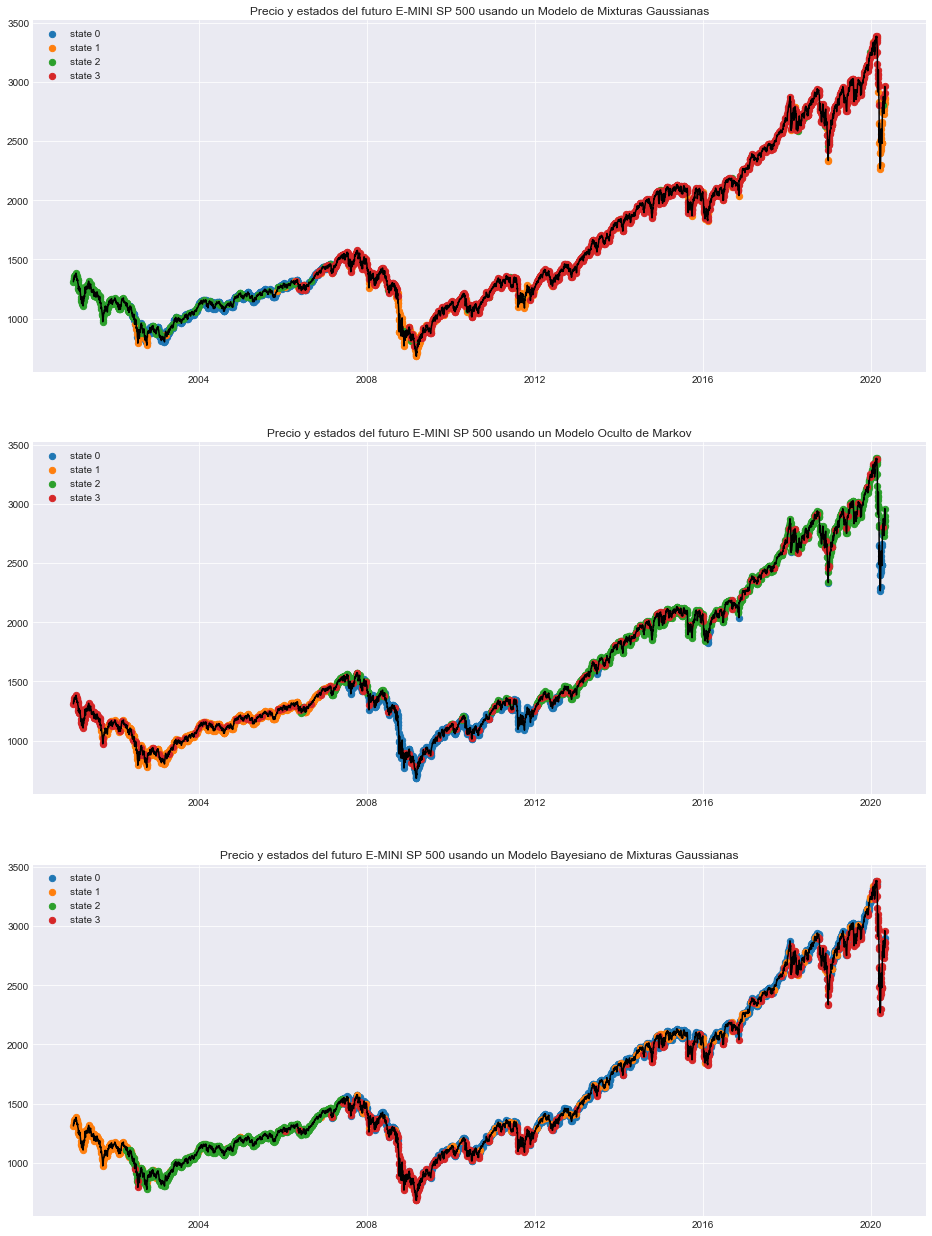

In [18]:
raw = pd.read_csv("file:///" + os.path.join(DATAPATH, files_list[7]), parse_dates=[['<DTYYYYMMDD>', '<TIME>']])
df = formatData(raw)

current_ticker = df.ticker.iloc[0]

df[TURNOVER] = df[VOLUME]*df[CLOSE_PRICE]
daily_data = get_daily_data(df)

log_returns = get_log_returns(daily_data)
adv_antilog = get_antilog_adv_median(daily_data)
mfi = get_money_flow_index(daily_data)
betas_mkt_impact = get_beta_market_impact(daily_data)
log_traded_vol = get_log_total_trade_vol(daily_data)

features = [log_traded_vol, betas_mkt_impact, mfi, adv_antilog, log_returns]
features_df = getFeaturesDf(features)

train_data, test_data = splitTrainTestData(features_df, 2)

best_gmm, features_gmm, scores_gmm = get_best_gmm_aic_bic(features, pca_flag=False)
best_ghmm, features_ghmm, scores_ghmm = get_best_ghmm_aic_bic(features, pca_flag=False)
best_bgm, features_bgm, scores_bgm = get_best_bgm_aic_bic(features, pca_flag=False)

fig, ax = plt.subplots(nrows=3, ncols=1);
fig.set_size_inches(16,22);

gmm_title = "Precio y estados del futuro E-MINI SP 500 usando un Modelo de Mixturas Gaussianas"
plot_time_series_states(best_gmm, daily_data, features_df, features_gmm, ax[0], gmm_title)

ghmm_title = "Precio y estados del futuro E-MINI SP 500 usando un Modelo Oculto de Markov"
plot_time_series_states(best_ghmm, daily_data, features_df, features_ghmm, ax[1], ghmm_title)

bgm_title = "Precio y estados del futuro E-MINI SP 500 usando un Modelo Bayesiano de Mixturas Gaussianas"
plot_time_series_states(best_bgm, daily_data, features_df, features_bgm, ax[2], bgm_title)

Optimal params are {'n_components': 2, 'covariance_type': 'tied', 'max_iter': 800} using ['volume', 'betas_market_impact', 'log_returns'] obtaining a Silhouette Score of 0.7421252482478701
Optimal params are {'n_components': 4, 'covariance_type': 'tied', 'max_iter': 800, 'algorithm': 'map'} using ['volume', 'betas_market_impact', 'log_returns'] obtaining a Silhouette Score of 0.6708318984055663
Optimal params are {'n_components': 2, 'covariance_type': 'tied', 'max_iter': 800, 'weight_concentration_prior_type': 'dirichlet_distribution'} using ['volume', 'betas_market_impact', 'log_returns'] obtaining a Silhouette Score of 0.7537694277313276


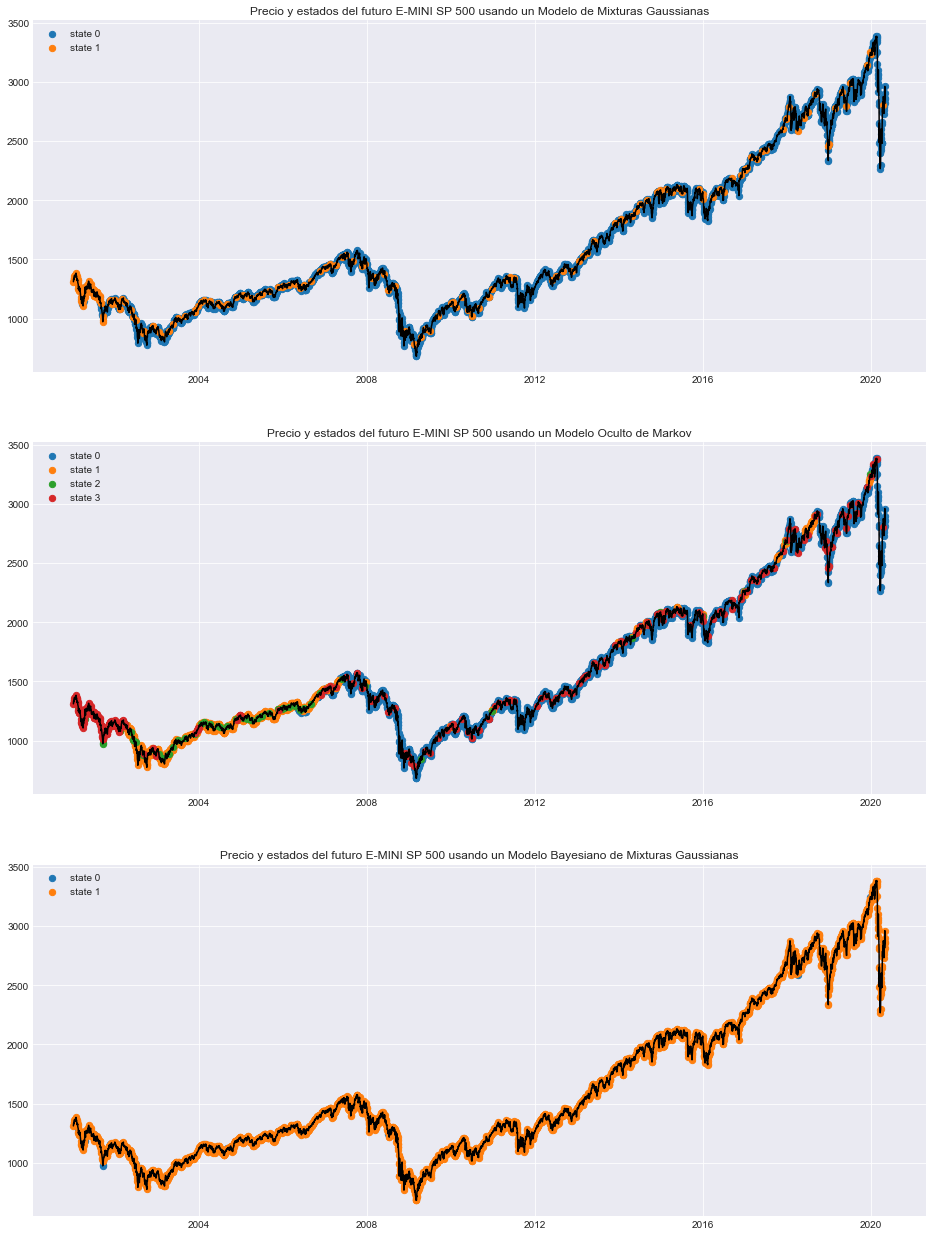

In [19]:
raw = pd.read_csv("file:///" + os.path.join(DATAPATH, files_list[7]), parse_dates=[['<DTYYYYMMDD>', '<TIME>']])
df = formatData(raw)

current_ticker = df.ticker.iloc[0]

df[TURNOVER] = df[VOLUME]*df[CLOSE_PRICE]
daily_data = get_daily_data(df)

log_returns = get_log_returns(daily_data)
adv_antilog = get_antilog_adv_median(daily_data)
mfi = get_money_flow_index(daily_data)
betas_mkt_impact = get_beta_market_impact(daily_data)
log_traded_vol = get_log_total_trade_vol(daily_data)

features = [log_traded_vol, betas_mkt_impact, mfi, adv_antilog, log_returns]
features_df = getFeaturesDf(features)

train_data, test_data = splitTrainTestData(features_df, 2)

best_gmm, features_gmm, scores_gmm = get_best_gmm(features, pca_flag=False)
best_ghmm, features_ghmm, scores_ghmm = get_best_ghmm(features, pca_flag=False)
best_bgm, features_bgm, scores_bgm = get_best_bgm(features, pca_flag=False)

fig, ax = plt.subplots(nrows=3, ncols=1);
fig.set_size_inches(16,22);

gmm_title = "Precio y estados del futuro E-MINI SP 500 usando un Modelo de Mixturas Gaussianas"
plot_time_series_states(best_gmm, daily_data, features_df, features_gmm, ax[0], gmm_title)

ghmm_title = "Precio y estados del futuro E-MINI SP 500 usando un Modelo Oculto de Markov"
plot_time_series_states(best_ghmm, daily_data, features_df, features_ghmm, ax[1], ghmm_title)

bgm_title = "Precio y estados del futuro E-MINI SP 500 usando un Modelo Bayesiano de Mixturas Gaussianas"
plot_time_series_states(best_bgm, daily_data, features_df, features_bgm, ax[2], bgm_title)

Optimal params are {'n_components': 4, 'covariance_type': 'full', 'max_iter': 400} using ['volume', 'betas_market_impact', 'money_flow_index', 'antilog_adv', 'log_returns'] obtaining a Combined BIC-AIC score of -46080.2185844023
Scores obtained -> BIC: -45817.627981130485, AIC: -46342.80918767411, SC: 0.38186687119412177
Optimal params are {'n_components': 4, 'covariance_type': 'full', 'max_iter': 800, 'algorithm': 'map'} using ['volume', 'betas_market_impact', 'money_flow_index', 'antilog_adv', 'log_returns'] obtaining a Combined BIC-AIC score of -225637796.79646188
Scores obtained -> BIC: -225637534.20585862, AIC: -225638059.38706517, SC: -0.3283145253868127
Optimal params are {'n_components': 4, 'covariance_type': 'full', 'max_iter': 200, 'weight_concentration_prior_type': 'dirichlet_distribution'} using ['volume', 'betas_market_impact', 'money_flow_index', 'antilog_adv', 'log_returns'] obtaining a Combined BIC-AIC score of -46091.674190467726
Scores obtained -> BIC: -45829.08358719

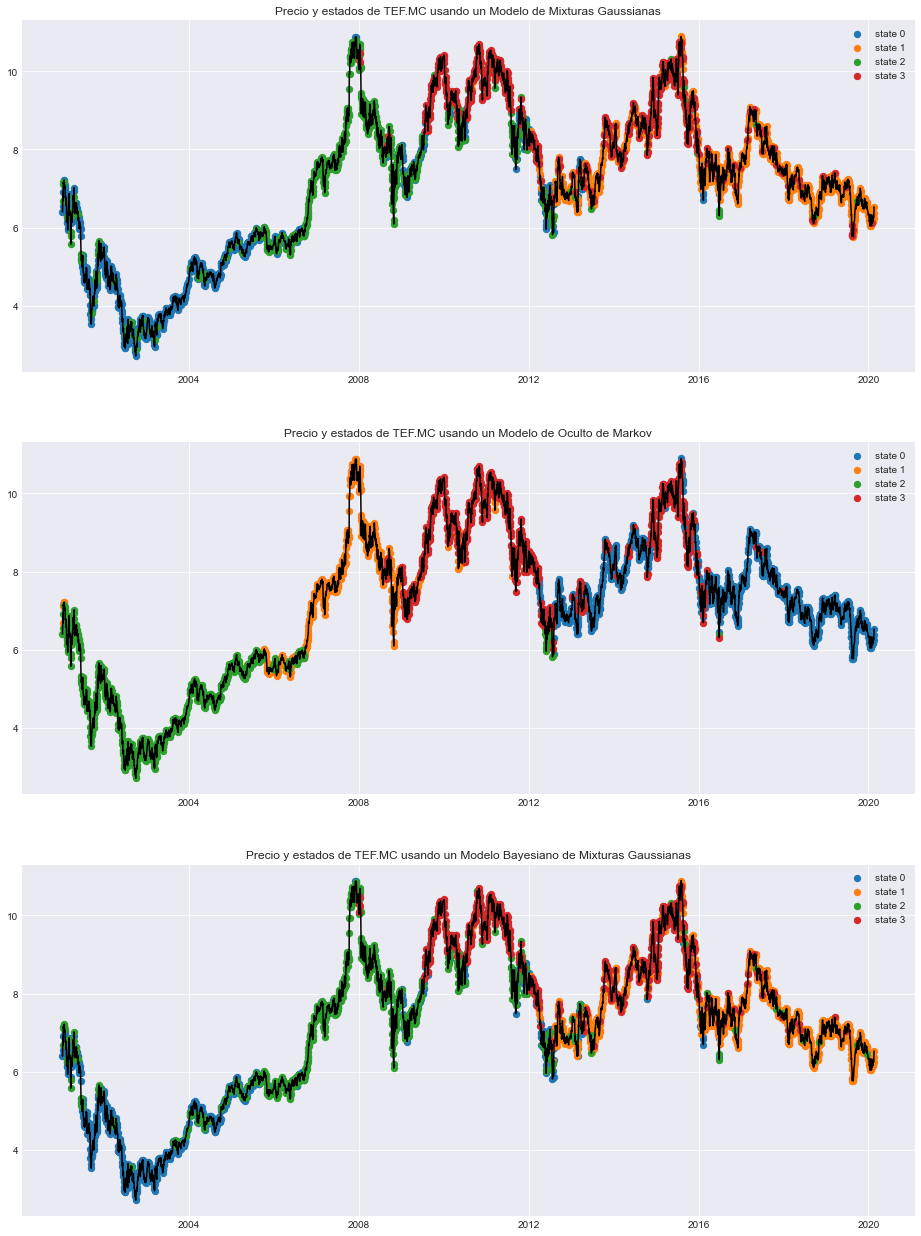

In [23]:
raw = pd.read_csv("file:///" + os.path.join(DATAPATH, "TEF.txt"), parse_dates=[['<DTYYYYMMDD>', '<TIME>']])
df = formatData(raw)

current_ticker = df.ticker.iloc[0]

df[TURNOVER] = df[VOLUME]*df[CLOSE_PRICE]
daily_data = get_daily_data(df)

log_returns = get_log_returns(daily_data)
adv_antilog = get_antilog_adv_median(daily_data)
mfi = get_money_flow_index(daily_data)
betas_mkt_impact = get_beta_market_impact(daily_data)
log_traded_vol = get_log_total_trade_vol(daily_data)

features = [log_traded_vol, betas_mkt_impact, mfi, adv_antilog, log_returns]
features_df = getFeaturesDf(features)

train_data, test_data = splitTrainTestData(features_df, 2)

best_gmm, features_gmm, scores_gmm = get_best_gmm_aic_bic(features, pca_flag=False)
best_ghmm, features_ghmm, scores_ghmm = get_best_ghmm_aic_bic(features, pca_flag=False)
best_bgm, features_bgm, scores_bgm = get_best_bgm_aic_bic(features, pca_flag=False)

fig, ax = plt.subplots(nrows=3, ncols=1);
fig.set_size_inches(16,22);

gmm_title = "Precio y estados de TEF.MC usando un Modelo de Mixturas Gaussianas"
plot_time_series_states(best_gmm, daily_data, features_df, features_gmm, ax[0], gmm_title)

ghmm_title = "Precio y estados de TEF.MC usando un Modelo de Oculto de Markov"
plot_time_series_states(best_ghmm, daily_data, features_df, features_ghmm, ax[1], ghmm_title)

bgm_title = "Precio y estados de TEF.MC usando un Modelo Bayesiano de Mixturas Gaussianas"
plot_time_series_states(best_bgm, daily_data, features_df, features_bgm, ax[2], bgm_title)

Optimal params are {'n_components': 4, 'covariance_type': 'diag', 'max_iter': 800} using ['volume', 'money_flow_index', 'antilog_adv'] obtaining a Silhouette Score of 0.5340434050818499
Optimal params are {'n_components': 3, 'covariance_type': 'spherical', 'max_iter': 800, 'algorithm': 'map'} using ['betas_market_impact', 'money_flow_index', 'log_returns'] obtaining a Silhouette Score of 0.383016131659924
Optimal params are {'n_components': 4, 'covariance_type': 'tied', 'max_iter': 800, 'weight_concentration_prior_type': 'dirichlet_distribution'} using ['volume', 'money_flow_index', 'antilog_adv'] obtaining a Silhouette Score of 0.5757529543058285


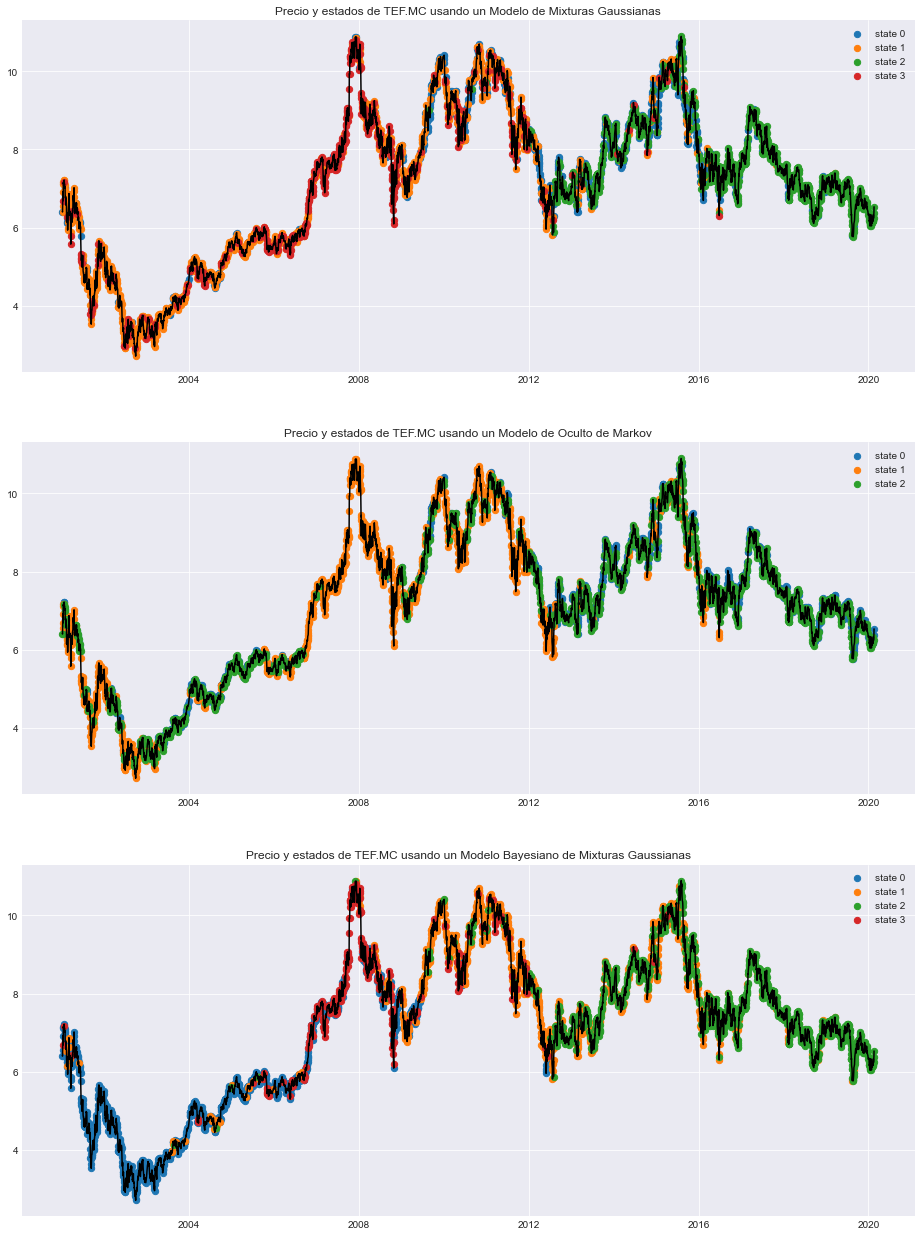

In [24]:
raw = pd.read_csv("file:///" + os.path.join(DATAPATH, "TEF.txt"), parse_dates=[['<DTYYYYMMDD>', '<TIME>']])
df = formatData(raw)

current_ticker = df.ticker.iloc[0]

df[TURNOVER] = df[VOLUME]*df[CLOSE_PRICE]
daily_data = get_daily_data(df)

log_returns = get_log_returns(daily_data)
adv_antilog = get_antilog_adv_median(daily_data)
mfi = get_money_flow_index(daily_data)
betas_mkt_impact = get_beta_market_impact(daily_data)
log_traded_vol = get_log_total_trade_vol(daily_data)

features = [log_traded_vol, betas_mkt_impact, mfi, adv_antilog, log_returns]
features_df = getFeaturesDf(features)

train_data, test_data = splitTrainTestData(features_df, 2)

best_gmm, features_gmm, scores_gmm = get_best_gmm(features, pca_flag=False)
best_ghmm, features_ghmm, scores_ghmm = get_best_ghmm(features, pca_flag=False)
best_bgm, features_bgm, scores_bgm = get_best_bgm(features, pca_flag=False)

fig, ax = plt.subplots(nrows=3, ncols=1);
fig.set_size_inches(16,22);

gmm_title = "Precio y estados de TEF.MC usando un Modelo de Mixturas Gaussianas"
plot_time_series_states(best_gmm, daily_data, features_df, features_gmm, ax[0], gmm_title)

ghmm_title = "Precio y estados de TEF.MC usando un Modelo de Oculto de Markov"
plot_time_series_states(best_ghmm, daily_data, features_df, features_ghmm, ax[1], ghmm_title)

bgm_title = "Precio y estados de TEF.MC usando un Modelo Bayesiano de Mixturas Gaussianas"
plot_time_series_states(best_bgm, daily_data, features_df, features_bgm, ax[2], bgm_title)

### Get Scores per Model and Instrument using BIC/AIC

In [13]:
def get_scores_per_model_bic_aic(file):
    raw = pd.read_csv("file:///" + os.path.join(DATAPATH, file), parse_dates=[['<DTYYYYMMDD>', '<TIME>']])
    df = formatData(raw)

    current_ticker = df.ticker.iloc[0]

    df[TURNOVER] = df[VOLUME]*df[CLOSE_PRICE]
    daily_data = get_daily_data(df)

    log_returns = get_log_returns(daily_data)
    adv_antilog = get_antilog_adv_median(daily_data)
    mfi = get_money_flow_index(daily_data)
    betas_mkt_impact = get_beta_market_impact(daily_data)
    log_traded_vol = get_log_total_trade_vol(daily_data)

    features = [log_traded_vol, betas_mkt_impact, mfi, adv_antilog, log_returns]
    features_df = getFeaturesDf(features)

    train_data, test_data = splitTrainTestData(features_df, 2)

    best_gmm, features_gmm, scores_gmm = get_best_gmm_aic_bic(features, pca_flag=False)
    best_ghmm, features_ghmm, scores_ghmm = get_best_ghmm_aic_bic(features, pca_flag=False)
    best_bgm, features_bgm, scores_bgm = get_best_bgm_aic_bic(features, pca_flag=False)
    
    cov_type_gmm = best_gmm.covariance_type
    n_components_gmm = best_gmm.n_components
    max_iters_gmm = best_gmm.max_iter
    
    cov_type_bgm = best_bgm.covariance_type
    n_components_bgm = best_bgm.n_components
    max_iters_bgm = best_bgm.max_iter
    w_c_prior_type = best_bgm.weight_concentration_prior_type
    
    cov_type_ghmm = best_ghmm.covariance_type
    n_components_ghmm = best_ghmm.n_components
    max_iters_ghmm = best_ghmm.n_iter
    algorithm_type = best_ghmm.algorithm
    
    ric=[ric_ticker_dict(current_ticker)]

    dict_gmm = {'n_components': n_components_gmm, 
                'cov_type': cov_type_gmm,
                'n_iters': max_iters_gmm}
    params_df_gmm = pd.DataFrame(data=dict_gmm, index=ric)
    
    dict_bgm = {'n_components': n_components_bgm, 
                'cov_type': cov_type_bgm, 
                'n_iters': max_iters_bgm,
                'w_c_prior_type': w_c_prior_type}
    params_df_bgm = pd.DataFrame(data=dict_bgm, index=ric)
    
    dict_ghmm = {'n_components': n_components_ghmm, 
                'cov_type': cov_type_ghmm, 
                'n_iters': max_iters_ghmm,
                'algorithm': algorithm_type}
    params_df_ghmm = pd.DataFrame(data=dict_ghmm, index=ric)
    
    r_df_gmm = pd.DataFrame(data=scores_gmm, index=ric)
    r_df_ghmm = pd.DataFrame(data=scores_ghmm, index=ric)
    r_df_bgm = pd.DataFrame(data=scores_bgm, index=ric)
    
    return params_df_gmm, params_df_ghmm, params_df_bgm, r_df_gmm, r_df_ghmm, r_df_bgm

def get_scores_per_model_sc(file):
    raw = pd.read_csv("file:///" + os.path.join(DATAPATH, file), parse_dates=[['<DTYYYYMMDD>', '<TIME>']])
    df = formatData(raw)

    current_ticker = df.ticker.iloc[0]

    df[TURNOVER] = df[VOLUME]*df[CLOSE_PRICE]
    daily_data = get_daily_data(df)

    log_returns = get_log_returns(daily_data)
    adv_antilog = get_antilog_adv_median(daily_data)
    mfi = get_money_flow_index(daily_data)
    betas_mkt_impact = get_beta_market_impact(daily_data)
    log_traded_vol = get_log_total_trade_vol(daily_data)

    features = [log_traded_vol, betas_mkt_impact, mfi, adv_antilog, log_returns]
    features_df = getFeaturesDf(features)

    train_data, test_data = splitTrainTestData(features_df, 2)

    best_gmm, features_gmm, scores_gmm = get_best_gmm(features, pca_flag=False)
    best_ghmm, features_ghmm, scores_ghmm = get_best_ghmm(features, pca_flag=False)
    best_bgm, features_bgm, scores_bgm = get_best_bgm(features, pca_flag=False)
    
    cov_type_gmm = best_gmm.covariance_type
    n_components_gmm = best_gmm.n_components
    max_iters_gmm = best_gmm.max_iter
    
    cov_type_bgm = best_bgm.covariance_type
    n_components_bgm = best_bgm.n_components
    max_iters_bgm = best_bgm.max_iter
    w_c_prior_type = best_bgm.weight_concentration_prior_type
    
    cov_type_ghmm = best_ghmm.covariance_type
    n_components_ghmm = best_ghmm.n_components
    max_iters_ghmm = best_ghmm.n_iter
    algorithm_type = best_ghmm.algorithm
    
    ric=[ric_ticker_dict(current_ticker)]

    dict_gmm = {'n_components': n_components_gmm, 
                'cov_type': cov_type_gmm,
                'n_iters': max_iters_gmm}
    params_df_gmm = pd.DataFrame(data=dict_gmm, index=ric)
    
    dict_bgm = {'n_components': n_components_bgm, 
                'cov_type': cov_type_bgm, 
                'n_iters': max_iters_bgm,
                'w_c_prior_type': w_c_prior_type}
    params_df_bgm = pd.DataFrame(data=dict_bgm, index=ric)
    
    dict_ghmm = {'n_components': n_components_ghmm, 
                'cov_type': cov_type_ghmm, 
                'n_iters': max_iters_ghmm,
                'algorithm': algorithm_type}
    params_df_ghmm = pd.DataFrame(data=dict_ghmm, index=ric)
    
    r_df_gmm = pd.DataFrame(data=scores_gmm, index=ric)
    r_df_ghmm = pd.DataFrame(data=scores_ghmm, index=ric)
    r_df_bgm = pd.DataFrame(data=scores_bgm, index=ric)
    
    return params_df_gmm, params_df_ghmm, params_df_bgm, r_df_gmm, r_df_ghmm, r_df_bgm

def get_scores_and_params_all_instruments(files_list, bic_aic_flag=True):
    first=True
    
    for file in files_list:
        if bic_aic_flag:
            this_params_gmm, this_params_ghmm, this_params_bgm, this_r_gmm, this_r_ghmm, this_r_bgm = get_scores_per_model_bic_aic(file)
        else:
            this_params_gmm, this_params_ghmm, this_params_bgm, this_r_gmm, this_r_ghmm, this_r_bgm = get_scores_per_model_sc(file)
            
        if first:
            params_gmm = this_params_gmm
            params_ghmm = this_params_ghmm
            params_bgm = this_params_bgm
            
            r_gmm = this_r_gmm
            r_ghmm = this_r_ghmm
            r_bgm = this_r_bgm
            first = False
        else:
            params_gmm = pd.concat([this_params_gmm, params_gmm])
            params_ghmm = pd.concat([this_params_ghmm, params_ghmm])
            params_bgm = pd.concat([this_params_bgm, params_bgm])
            
            r_gmm = pd.concat([this_r_gmm, r_gmm])
            r_ghmm = pd.concat([this_r_ghmm, r_ghmm])
            r_bgm = pd.concat([this_r_bgm, r_bgm])
            
    return params_gmm, params_ghmm, params_bgm, r_gmm, r_ghmm, r_bgm

## Get best model using BIC/AIC criteria

In [ ]:
opt_params_gmm, opt_params_ghmm, opt_params_bgm, results_gmm, results_ghmm, results_bgm = get_scores_and_params_all_instruments(files_list)

In [46]:
opt_params_bgm.sort_index()

,n_components,cov_type,n_iters,w_c_prior_type
AAPL.OQ,4,full,400,dirichlet_distribution
AIR.PA,4,full,800,dirichlet_distribution
BA.N,4,full,400,dirichlet_distribution
BBVA.MC,4,full,200,dirichlet_distribution
BMWG.DE,4,full,100,dirichlet_distribution
BOBL,4,full,100,dirichlet_distribution
BUND,4,full,800,dirichlet_distribution
CBKG.DE,4,full,400,dirichlet_distribution
DGE.L,4,full,200,dirichlet_distribution
ENGIE.PA,4,full,400,dirichlet_process


In [41]:
results_bgm.sort_index()

,bic,aic,sc
AAPL.OQ,-45848.085600,-46369.510695,0.492133
AIR.PA,-48667.440373,-49175.202065,0.491666
BA.N,-37642.006166,-38128.209173,-0.056385
BBVA.MC,-49662.490662,-50187.309861,0.245006
BMWG.DE,-43362.190977,-43870.347791,0.484565
BOBL,-70773.497149,-71299.477207,0.235790
BUND,-62177.667347,-62704.379559,0.300449
CBKG.DE,-47771.022923,-48284.360713,0.000000
DGE.L,-30800.332234,-31144.467878,0.398616
ENGIE.PA,-48109.629878,-48610.638623,0.253245


In [47]:
results_ghmm.sort_index()

,bic,aic,sc
AAPL.OQ,-2.247727e+08,-2.247733e+08,-0.211512
AIR.PA,-1.828467e+08,-1.828472e+08,0.140667
BA.N,-1.115795e+08,-1.115800e+08,0.152872
BBVA.MC,-2.389242e+08,-2.389247e+08,0.198913
BMWG.DE,-1.715351e+08,-1.715356e+08,0.104833
BOBL,-3.137052e+08,-3.137058e+08,0.264312
BUND,-2.915457e+08,-2.915462e+08,0.283723
CBKG.DE,-1.985649e+08,-1.985654e+08,0.179702
DGE.L,-8.728533e+07,-8.728567e+07,-0.032571
ENGIE.PA,-1.689916e+08,-1.689921e+08,0.388615


In [43]:
opt_params_ghmm.sort_index()

,n_components,cov_type,n_iters,algorithm
AAPL.OQ,4,full,200,map
AIR.PA,4,full,800,viterbi
BA.N,4,full,200,map
BBVA.MC,4,full,200,viterbi
BMWG.DE,4,full,400,viterbi
BOBL,4,full,800,viterbi
BUND,4,full,100,viterbi
CBKG.DE,4,full,100,viterbi
DGE.L,4,full,400,viterbi
ENGIE.PA,4,full,200,map


In [44]:
opt_params_gmm.sort_index()

,n_components,cov_type,n_iters
AAPL.OQ,4,full,200
AIR.PA,4,full,400
BA.N,4,full,200
BBVA.MC,4,full,200
BMWG.DE,4,full,800
BOBL,4,full,200
BUND,4,full,800
CBKG.DE,4,full,400
DGE.L,4,full,200
ENGIE.PA,4,full,100


In [45]:
results_gmm.sort_index()

,bic,aic,sc
AAPL.OQ,-47656.133815,-48177.558910,0.492133
AIR.PA,-48753.957907,-49261.719599,0.000000
BA.N,-37695.138889,-38181.341896,0.031658
BBVA.MC,-49786.549292,-50311.368491,0.242808
BMWG.DE,-43407.583199,-43915.740012,0.490611
BOBL,-70446.229703,-70972.209761,0.146879
BUND,-62685.767617,-63212.479829,0.000000
CBKG.DE,-48128.626043,-48641.963833,0.000000
DGE.L,-30577.064932,-30921.200575,0.398616
ENGIE.PA,-48207.516472,-48708.525217,0.097668


In [53]:
excels_paths = os.getcwd()[:17]+'Excels\\'

## Get best model using SC criteria

In [16]:
opt_params_gmm, opt_params_ghmm, opt_params_bgm, results_gmm, results_ghmm, results_bgm = get_scores_and_params_all_instruments(files_list, bic_aic_flag=False)

Optimal params are {'n_components': 3, 'covariance_type': 'diag', 'max_iter': 800} using ['volume', 'money_flow_index', 'antilog_adv'] obtaining a Silhouette Score of 0.6283350228240595
Optimal params are {'n_components': 2, 'covariance_type': 'diag', 'max_iter': 800, 'algorithm': 'map'} using ['volume', 'money_flow_index', 'log_returns'] obtaining a Silhouette Score of 0.5103922964186328
Optimal params are {'n_components': 2, 'covariance_type': 'spherical', 'max_iter': 800, 'weight_concentration_prior_type': 'dirichlet_distribution'} using ['volume', 'money_flow_index', 'antilog_adv'] obtaining a Silhouette Score of 0.6283350228240595
Optimal params are {'n_components': 2, 'covariance_type': 'tied', 'max_iter': 800} using ['volume', 'betas_market_impact', 'money_flow_index'] obtaining a Silhouette Score of 0.7333488016678413
Optimal params are {'n_components': 2, 'covariance_type': 'spherical', 'max_iter': 800, 'algorithm': 'map'} using ['volume', 'betas_market_impact', 'log_returns']

Optimal params are {'n_components': 4, 'covariance_type': 'tied', 'max_iter': 800, 'weight_concentration_prior_type': 'dirichlet_distribution'} using ['volume', 'money_flow_index', 'antilog_adv'] obtaining a Silhouette Score of 0.6513829043092235
Optimal params are {'n_components': 4, 'covariance_type': 'spherical', 'max_iter': 800} using ['volume', 'betas_market_impact', 'antilog_adv'] obtaining a Silhouette Score of 0.6750662628768341
Optimal params are {'n_components': 4, 'covariance_type': 'diag', 'max_iter': 800, 'algorithm': 'map'} using ['volume', 'betas_market_impact', 'antilog_adv'] obtaining a Silhouette Score of 0.6750662628768341
Optimal params are {'n_components': 4, 'covariance_type': 'spherical', 'max_iter': 800, 'weight_concentration_prior_type': 'dirichlet_distribution'} using ['volume', 'betas_market_impact', 'antilog_adv'] obtaining a Silhouette Score of 0.6750662628768341
Optimal params are {'n_components': 4, 'covariance_type': 'tied', 'max_iter': 200} using ['volu

Optimal params are {'n_components': 3, 'covariance_type': 'tied', 'max_iter': 800, 'algorithm': 'map'} using ['volume', 'money_flow_index', 'log_returns'] obtaining a Silhouette Score of 0.7456494631970225
Optimal params are {'n_components': 4, 'covariance_type': 'tied', 'max_iter': 800, 'weight_concentration_prior_type': 'dirichlet_distribution'} using ['volume', 'money_flow_index', 'antilog_adv'] obtaining a Silhouette Score of 0.7842437722006076


In [25]:
opt_params_gmm.sort_index()

,n_components,cov_type,n_iters
AAPL.OQ,3,diag,800
AIR.PA,2,tied,800
BA.N,3,tied,800
BBVA.MC,2,tied,800
BMWG.DE,3,tied,800
BOBL,4,tied,800
BUND,3,tied,800
CBKG.DE,2,tied,800
DGE.L,3,spherical,800
ENGIE.PA,4,full,100


In [26]:
opt_params_bgm.sort_index()

,n_components,cov_type,n_iters,w_c_prior_type
AAPL.OQ,2,spherical,800,dirichlet_distribution
AIR.PA,2,tied,200,dirichlet_process
BA.N,3,spherical,200,dirichlet_process
BBVA.MC,2,tied,800,dirichlet_distribution
BMWG.DE,4,tied,800,dirichlet_distribution
BOBL,4,tied,400,dirichlet_process
BUND,4,tied,800,dirichlet_distribution
CBKG.DE,4,tied,800,dirichlet_distribution
DGE.L,4,spherical,100,dirichlet_distribution
ENGIE.PA,4,tied,400,dirichlet_distribution


In [27]:
opt_params_ghmm.sort_index()

,n_components,cov_type,n_iters,algorithm
AAPL.OQ,2,diag,800,map
AIR.PA,2,spherical,800,map
BA.N,4,spherical,800,map
BBVA.MC,2,full,800,map
BMWG.DE,4,spherical,800,map
BOBL,2,diag,800,map
BUND,4,full,800,map
CBKG.DE,4,tied,800,map
DGE.L,4,tied,800,map
ENGIE.PA,4,tied,800,map


In [28]:
results_gmm.sort_index()

,aic,bic,sc
AAPL.OQ,-20398.101872,-20398.101872,0.628335
AIR.PA,-30444.380535,-30444.380535,0.733349
BA.N,-19654.594274,-19654.594274,0.493418
BBVA.MC,-32363.743128,-32363.743128,0.619188
BMWG.DE,-26914.414319,-26914.414319,0.596833
BOBL,-48085.790286,-48085.790286,0.716458
BUND,-33008.989447,-33008.989447,0.670667
CBKG.DE,-26103.689528,-26103.689528,0.499878
DGE.L,-17309.353821,-17309.353821,0.649128
ENGIE.PA,-36470.363604,-36470.363604,0.495280


In [29]:
results_bgm.sort_index()

,aic,bic,sc
AAPL.OQ,-17521.806470,-17521.806470,0.628335
AIR.PA,-31028.151351,-31028.151351,0.723125
BA.N,-16032.729152,-16032.729152,0.485411
BBVA.MC,-32350.954361,-32350.954361,0.619188
BMWG.DE,-27308.169135,-27308.169135,0.596833
BOBL,-48329.611230,-48329.611230,0.716458
BUND,-33042.092473,-33042.092473,0.670667
CBKG.DE,-23869.059331,-23869.059331,0.534195
DGE.L,-17472.379380,-17472.379380,0.649128
ENGIE.PA,-26521.888686,-26521.888686,0.537925


In [30]:
results_ghmm.sort_index()

,aic,bic,sc
AAPL.OQ,-9.530727e+07,-9.530727e+07,0.510392
AIR.PA,-9.688691e+07,-9.688691e+07,0.595211
BA.N,-6.464952e+07,-6.464952e+07,0.411745
BBVA.MC,-1.370759e+08,-1.370759e+08,0.588305
BMWG.DE,-1.007321e+08,-1.007321e+08,0.577795
BOBL,-1.771059e+08,-1.771059e+08,0.650456
BUND,-2.301200e+08,-2.301200e+08,0.609134
CBKG.DE,-1.120407e+08,-1.120407e+08,0.476285
DGE.L,-6.180427e+07,-6.180427e+07,0.654711
ENGIE.PA,-1.017830e+08,-1.017830e+08,0.571262
